<a href="https://colab.research.google.com/github/Jovalam3008/Movie_Recommender_System_ML/blob/main/Movie_Recommender_System_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PROBLEMA DE NEGOCIO**


---




##Imagina tener acceso a los datos de una plataforma de streaming y usar esos datos para mejorar la experiencia del usuario. Se analizarán estos datos con Python y construirán un recomendador de películas personalizado que ofrecerá sugerencias precisas y relevantes, revolucionando la forma en que los usuarios descubren nuevos contenidos.

### **Objetivos**

1. Recomendador no personalizado

2. Recomendador Content-based

3. Recomendador Collaborative filtering

#**1. Configuración del Ambiente**


---




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import zipfile
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import linear_kernel
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
!curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
global df_movies, df_ratings, df_final

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  1603k      0 --:--:-- --:--:-- --:--:-- 1605k


#**2. Obtención, Tratamiento y Análisis Exploratório (EDA)**


---




##**2.1 Cargando las bases de datos**

In [ ]:
df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.00,964982703
1,1,3,4.00,964981247
2,1,6,4.00,964982224
3,1,47,5.00,964983815
4,1,50,5.00,964982931


##**2.2 Tratamiento de Datos**

In [ ]:
print(df_movies.info())
print('-------------')
print(df_ratings.info())
print('-------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
-------------


In [ ]:
print(df_movies.isnull().sum())
print(df_ratings.isnull().sum())

movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [ ]:
def preprocesamiento():
  global df_movies, df_ratings
  # Eliminar duplicados en df_movies usando movieId como llave
  df_movies = df_movies.drop_duplicates(subset='movieId')

  # Eliminar duplicados en df_ratings usando movieId y userId como llaves
  df_ratings = df_ratings.drop_duplicates(subset=['movieId', 'userId'])

  # Crear columna 'content' en df_movies reemplazando '|' por espacios en la columna genres
  df_movies['content'] = df_movies['genres'].str.replace('|', ' ')

  # Crear columna 'genre_set' como un conjunto (set) de géneros separados por comas
  df_movies['genre_set'] = df_movies['genres'].apply(lambda x: set(x.split('|')))

  # Asegurar que todas las columnas tengan el tipo de dato correcto
  df_movies['movieId'] = df_movies['movieId'].astype(int)
  df_movies['title'] = df_movies['title'].astype(str)
  df_movies['genres'] = df_movies['genres'].astype(str)

  df_ratings['userId'] = df_ratings['userId'].astype(int)
  df_ratings['movieId'] = df_ratings['movieId'].astype(int)
  df_ratings['rating'] = df_ratings['rating'].astype(float)
  df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s')  # Convertir timestamp a datetime


In [ ]:
preprocesamiento()
print(df_movies.info())
print('-------------')
print(df_ratings.info())
print('-------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movieId    9742 non-null   int64 
 1   title      9742 non-null   object
 2   genres     9742 non-null   object
 3   content    9742 non-null   object
 4   genre_set  9742 non-null   object
dtypes: int64(1), object(4)
memory usage: 380.7+ KB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64         
 1   movieId    100836 non-null  int64         
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.1 MB
None
-------------


In [ ]:
df_movies.head()

,movieId,title,genres,content,genre_set
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Fantasy, Animation, Comedy, Children, Adventure}"
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure Children Fantasy,"{Children, Fantasy, Adventure}"
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy Romance,"{Comedy, Romance}"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy Drama Romance,"{Drama, Comedy, Romance}"
4,5,Father of the Bride Part II (1995),Comedy,Comedy,{Comedy}


In [ ]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.00,2000-07-30 18:45:03
1,1,3,4.00,2000-07-30 18:20:47
2,1,6,4.00,2000-07-30 18:37:04
3,1,47,5.00,2000-07-30 19:03:35
4,1,50,5.00,2000-07-30 18:48:51


##**2.3 Análisis Exploratorio (EDA)**

In [ ]:
df_movies.describe()

,movieId
count,9742.00
mean,42200.35
std,52160.49
min,1.00
25%,3248.25
50%,7300.00
75%,76232.00
max,193609.00


In [ ]:
# Agrupar por movieId y contar el número de votos por película
votos_por_pelicula = df_ratings.groupby('movieId').size().reset_index(name='total_votos')

# Dividir la columna 'genres' en géneros individuales y contarlos
todos_los_generos = df_movies['genres'].str.split('|').explode()
conteo_generos = Counter(todos_los_generos)

#Convertir el conteo de géneros en un DataFrame
df_conteo_generos = pd.DataFrame(conteo_generos.items(), columns=['Género', 'Conteo']).sort_values(by='Conteo', ascending=False)

# Calcular el porcentaje de cada género
df_conteo_generos['Porcentaje'] = (df_conteo_generos['Conteo'] / df_conteo_generos['Conteo'].sum()) * 100

# Crear la figura con subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Boxplot - Distribución del Total de Votos por Película
sns.boxplot(x=votos_por_pelicula['total_votos'], ax=axes[0])
axes[0].set_xlim(0, 22)  # Limitar el eje X
axes[0].set_title('Distribución del Total de Votos por Película')
axes[0].set_xlabel('Número de Votos')

from collections import Counter

# Barras Horizontales - Distribución de Géneros de Películas
sns.barplot(x='Conteo', y='Género', data=df_conteo_generos, palette='viridis', ax=axes[1])
for i, (conteo, porcentaje) in enumerate(zip(df_conteo_generos['Conteo'], df_conteo_generos['Porcentaje'])):
    axes[1].text(conteo + 10, i, f'{porcentaje:.2f}%', color='black', va='center')
axes[1].set_title('Distribución de Géneros de Películas')
axes[1].set_xlabel('Número de Películas')
axes[1].set_ylabel('Género')

plt.tight_layout()
plt.show()

NameError: name 'Counter' is not defined

In [ ]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,100836.00,100836.00,100836.00,100836
mean,326.13,19435.30,3.50,2008-03-19 17:01:27.368469248
min,1.00,1.00,0.50,1996-03-29 18:36:55
25%,177.00,1199.00,3.00,2002-04-18 09:57:46
50%,325.00,2991.00,3.50,2007-08-02 20:31:02
75%,477.00,8122.00,4.00,2015-07-04 07:15:44.500000
max,610.00,193609.00,5.00,2018-09-24 14:27:30
std,182.62,35530.99,1.04,NaN


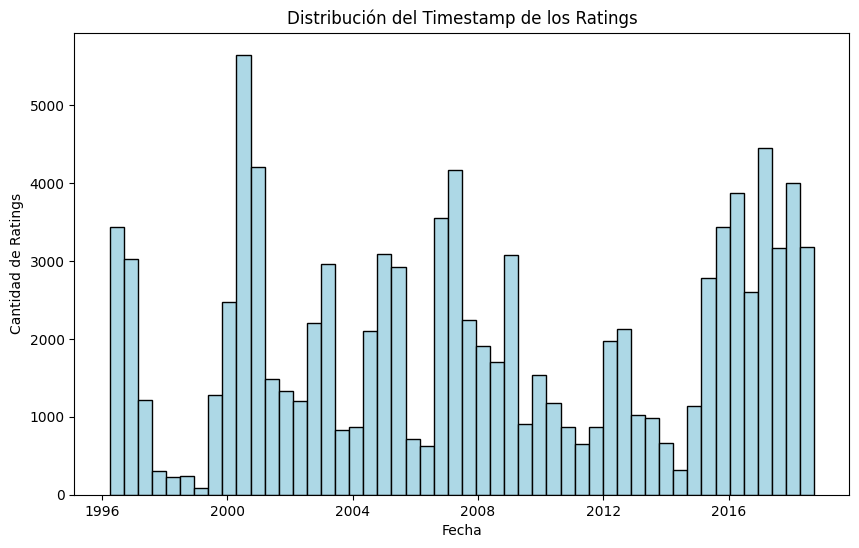

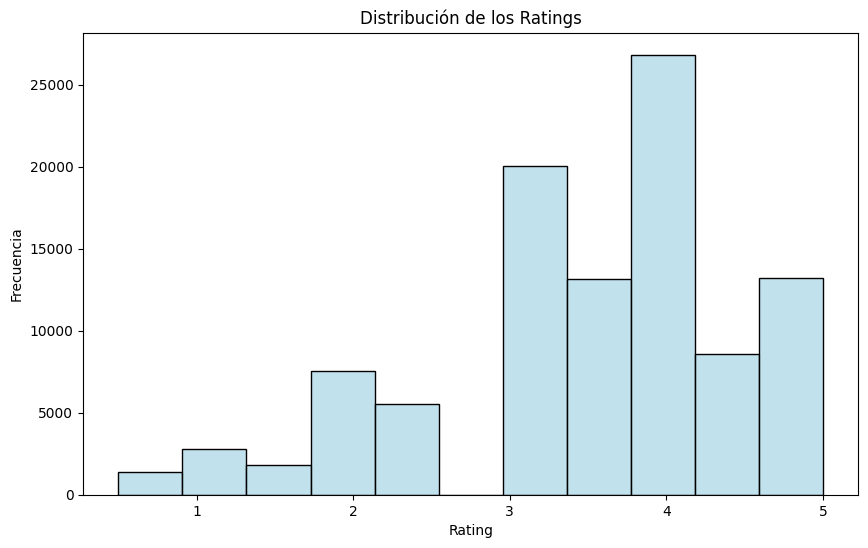

In [ ]:
# Convertir el timestamp a formato datetime
df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s')

# Crear el histograma del timestamp
plt.figure(figsize=(10, 6))
plt.hist(df_ratings['timestamp'], bins=50, color='lightblue', edgecolor='black')
plt.title('Distribución del Timestamp de los Ratings')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Ratings')
plt.show()

# Crear el histograma de la distribución del rating
plt.figure(figsize=(10, 6))
sns.histplot(df_ratings['rating'], bins=10, kde=False, binwidth=0.4, color='lightblue', edgecolor='black')
plt.title('Distribución de los Ratings')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.show()


In [ ]:
# Crear el DataFrame df_final, la intersección de df_ratings y df_movies por movieId
df_final = pd.merge(df_ratings, df_movies, on='movieId')

In [ ]:
df_final.describe()

,userId,movieId,rating,timestamp
count,100836.00,100836.00,100836.00,100836
mean,326.13,19435.30,3.50,2008-03-19 17:01:27.368469504
min,1.00,1.00,0.50,1996-03-29 18:36:55
25%,177.00,1199.00,3.00,2002-04-18 09:57:46
50%,325.00,2991.00,3.50,2007-08-02 20:31:02
75%,477.00,8122.00,4.00,2015-07-04 07:15:44.500000
max,610.00,193609.00,5.00,2018-09-24 14:27:30
std,182.62,35530.99,1.04,NaN


#**3. Estrategias de Recomendación**


---




##**3.1 Recomendación no personalizada**

In [ ]:
# Aplicando tecnicas avanzadas como el promedio bayesiano
def recomendacion_populares():
    # Definir las variables globales
    global df_final

    # Calcular cuántas veces ha sido votada cada película (usando la columna 'title')
    movie_vote_counts = df_final['title'].value_counts()

    # Calcular el rating promedio por película
    average_ratings = df_final.groupby(['movieId', 'title'])['rating'].mean()

    # Crear un nuevo DataFrame con las columnas mean_rating y vote_count
    df_movie_stats = pd.DataFrame({
        'mean_rating': average_ratings,
        'vote_count': df_final.groupby(['movieId', 'title']).size()
    }).reset_index()

    # Calcular el rating promedio de todas las películas
    C = df_movie_stats['mean_rating'].mean()

    # Calcular el umbral mínimo de votos (por ejemplo, el percentil 70 de los votos)
    m = df_movie_stats['vote_count'].quantile(0.70)

    # Crear una nueva columna weighted_score utilizando el promedio bayesiano
    df_movie_stats['weighted_score'] = (
        (df_movie_stats['vote_count'] / (df_movie_stats['vote_count'] + m)) * df_movie_stats['mean_rating'] +
        (m / (df_movie_stats['vote_count'] + m)) * C
    )

    # Filtrar las películas que tienen al menos m votos
    df_movie_stats = df_movie_stats[df_movie_stats['vote_count'] >= m]

    # Ordenar por weighted_score y obtener las 10 mejores películas
    top_10_movies = df_movie_stats.sort_values(by='weighted_score', ascending=False).head(10)

    # Retornar el DataFrame con los resultados
    return top_10_movies


In [ ]:
recomendacion_populares()

,movieId,title,mean_rating,vote_count,weighted_score
277,318,"Shawshank Redemption, The (1994)",4.43,317,4.40
659,858,"Godfather, The (1972)",4.29,192,4.25
2224,2959,Fight Club (1999),4.27,218,4.24
921,1221,"Godfather: Part II, The (1974)",4.26,129,4.21
46,50,"Usual Suspects, The (1995)",4.24,204,4.21
224,260,Star Wars: Episode IV - A New Hope (1977),4.23,251,4.20
602,750,Dr. Strangelove or: How I Learned to Stop Worr...,4.27,97,4.20
913,1213,Goodfellas (1990),4.25,126,4.20
461,527,Schindler's List (1993),4.22,220,4.20
6693,58559,"Dark Knight, The (2008)",4.24,149,4.19


##**3.2 Recomendación Content-Based**

###**3.2.1 Similitud de Jaccard**

In [ ]:
#@title
def recomendacion_jaccard(movie_id, df_movies, n_recommendations=10):
    #Tu código aquí
    return recommendations

In [ ]:
recomendaciones = recomendacion_jaccard(1, df_movies, n_recommendations=10)
recomendaciones

,movieId,title,genres,similarity
2355,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,1.00
6194,45074,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy,1.00
6948,65577,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy,1.00
2809,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,1.00
3568,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,1.00
8219,103755,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy,1.00
9430,166461,Moana (2016),Adventure|Animation|Children|Comedy|Fantasy,1.00
1706,2294,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy,1.00
3000,4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,1.00
7760,91355,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy,1.00


###**3.2.2 Similitud de Coseno con TF-IDF**

In [ ]:
#@title
def recomendacion_tf_idf(movie_id, df_movies, cosine_sim, n_recommendations=10):
    #Tu código aquí
    return df_movies

In [ ]:
recomendaciones = recomendacion_tf_idf(58559, df_movies, cosine_sim, n_recommendations=10)
recomendaciones

,movieId,title,genres,distance
8387,109850,Need for Speed (2014),Action|Crime|Drama|IMAX,1.00
5917,33794,Batman Begins (2005),Action|Crime|IMAX,0.96
7599,86644,"Fast Five (Fast and the Furious 5, The) (2011)",Action|Crime|Drama|Thriller|IMAX,0.93
6852,62081,Eagle Eye (2008),Action|Crime|Thriller|IMAX,0.89
8103,100498,"Good Day to Die Hard, A (2013)",Action|Crime|Thriller|IMAX,0.89
8166,102716,"Fast & Furious 6 (Fast and the Furious 6, The)...",Action|Crime|Thriller|IMAX,0.89
8149,102088,"Grandmaster, The (Yi dai zong shi) (2013)",Action|Drama|IMAX,0.89
7768,91529,"Dark Knight Rises, The (2012)",Action|Adventure|Crime|IMAX,0.87
8233,104129,Man of Tai Chi (2013),Action|IMAX,0.85
8201,103339,White House Down (2013),Action|Drama|Thriller|IMAX,0.82


##**3.3 Recomendación Collaborative Filtering**

In [ ]:
#@title
def recomendacion_knn(usuario_id_o_ratings, ratings_matrix_normalized, ratings_matrix, df_movies, knn_model, n_recommendations=10):
  #Tu código aquí
  return recommendations


In [ ]:
#usuario = 15
usuario = pd.Series({
    356: 4,
    58559: 5
})

recomendaciones = recomendacion_knn(usuario, ratings_matrix_normalized, ratings_matrix, df_movies, knn_model)
recomendaciones

,movieId,title,genres,mean_rating
1939,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.43
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,0.19
123,150,Apollo 13 (1995),Adventure|Drama|IMAX,0.19
659,858,"Godfather, The (1972)",Crime|Drama,0.18
287,329,Star Trek: Generations (1994),Adventure|Drama|Sci-Fi,0.17
322,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,0.17
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,0.16
6743,59315,Iron Man (2008),Action|Adventure|Sci-Fi,0.15
902,1200,Aliens (1986),Action|Adventure|Horror|Sci-Fi,0.14
6885,63082,Slumdog Millionaire (2008),Crime|Drama|Romance,0.13
